# SNR Threshold Finder Example

In [29]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from gwsnr.threshold import SNRThresholdFinder

np.random.seed(1234)

## With injection catalog as hf5 file 

In [4]:
# Example if you have the injection catalog file locally
# you can download the file for O4 injections from zenodo:
# !wget https://zenodo.org/records/16740117/files/samples-rpo4a_v2_20250503133839UTC-1366933504-23846400.hdf?download=1

# file_name = 'samples-rpo4a_v2_20250503133839UTC-1366933504-23846400.hdf'

# test = SNRThresholdFinder(
#     catalog_file = file_name,
#     # # below are all default values. You can omit them if you want. 
#     # npool=4,
#     # original_detection_statistic = dict(
#     #             key_name='gstlal_far',
#     #             threshold=1,  # 1 per year
#     #             parameter=None, # you can provide parameter values (np.ndarray) here if needed, if you don't want to use the catalog
#     #         ),
#     # projected_detection_statistic = dict(
#     #             key_name='observed_snr_net',
#     #             threshold=None, # to be determined
#     #             threshold_search_bounds=(6, 12),
#     #             parameter=None, # you can provide parameter values (np.ndarray) here if needed, if you don't want to use the catalog
#     #         ),
#     # parameters_to_fit = dict(
#     #     key_name = 'z',
#     #     parameter=None, # you can provide parameter values (np.ndarray) here if needed, if you don't want to use the catalog
#     # ),
#     # sample_size=20000,
#     # selection_range = dict(
#     #     key_name = 'mass1_source',
#     #     range = (30, 60), # in solar masses
#     #     parameter = None, # you can provide parameter values (np.ndarray) here if needed, if you don't want to use the catalog
#     # ),
#     # sample_size=20000,
#     # multiprocessing_verbose=True,
# )

In [5]:
# best_thr, del_H, H, H_true, snr_thrs = test.find_threshold(iteration=10, print_output=True, no_multiprocessing=True)

## With injection catalog parameters as numpy arrays

In [24]:
# injection_data_bbh.json is the reduced data extracted from the above hdf file for testing purpose
! wget https://raw.githubusercontent.com/hemantaph/gwsnr/refs/heads/main/tests/unit/injection_data_bbh.json

--2025-10-28 17:51:26--  https://raw.githubusercontent.com/hemantaph/gwsnr/refs/heads/main/tests/unit/injection_data_bbh.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2014143 (1.9M) [text/plain]
Saving to: ‘injection_data_bbh.json’

injection_data_bbh. 100%[===================>]   1.92M  11.4MB/s    in 0.2s    

2025-10-28 17:51:27 (11.4 MB/s) - ‘injection_data_bbh.json’ saved [2014143/2014143]



In [41]:
from gwsnr.utils import get_param_from_json
params = get_param_from_json('injection_data_bbh.json')

gstlal_far = params['gstlal_far']
observed_snr_net = params['observed_snr_net']
z = params['z']
mass1_source = params['mass1_source']

In [42]:
test = SNRThresholdFinder(
    catalog_file = None,
    # below are all default values. You can omit them if you want. 
    npool=4,
    original_detection_statistic = dict(
                key_name='gstlal_far',
                threshold=1,  # 1 per year
                parameter=gstlal_far,
            ),
    projected_detection_statistic = dict(
                key_name='observed_snr_net',
                threshold=None, # to be determined
                threshold_search_bounds=(6, 12),
                parameter=observed_snr_net,
            ),
    parameters_to_fit = dict(
        key_name = 'z',
        parameter=z,
    ),
    sample_size=20000,
    selection_range = dict(
        key_name = 'mass1_source',
        range = (30, 60), # in solar masses
        parameter = mass1_source,
    ),
)

In [43]:
best_thr, del_H, H, H_true, snr_thrs = test.find_threshold(iteration=10, print_output=True, no_multiprocessing=True)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]

Best SNR threshold: 9.33


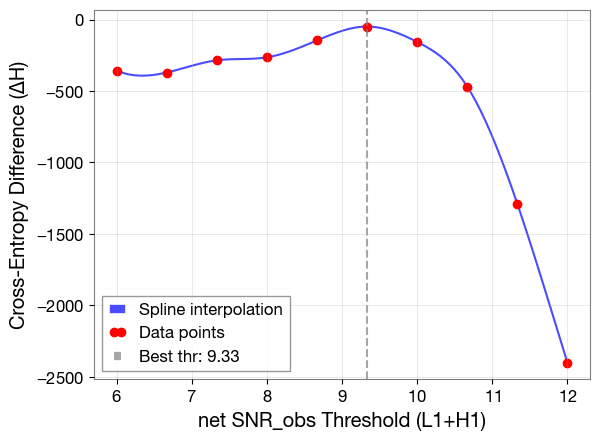

In [44]:
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt

spline = UnivariateSpline(snr_thrs, del_H, s=0)
snr_fine = np.linspace(snr_thrs.min(), snr_thrs.max(), 100)
del_H_fine = spline(snr_fine)
plt.plot(snr_fine, del_H_fine, 'b-', alpha=0.7, label='Spline interpolation')
plt.plot(snr_thrs, del_H, 'ro', markersize=6, label='Data points')
plt.axvline(best_thr, color='gray', linestyle='--', alpha=0.7, label=f'Best thr: {best_thr:.2f}')
plt.xlabel('net SNR_obs Threshold (L1+H1)')
plt.ylabel('Cross-Entropy Difference (ΔH)')
plt.grid(alpha=0.4) 
plt.legend()
plt.show()

### Visualizing how well the detectable population matches when using SNRth and FAR cutoffs as detection criteria

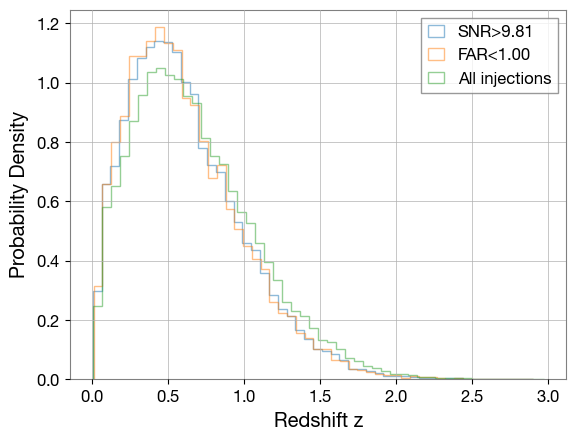

In [21]:
snr_th = best_thr
plt.hist(z[observed_snr_net>=snr_th], bins=50, density=True, alpha=0.5, color='C0', histtype='step', label=f'SNR>{best_thr:.2f}')
far_th = 1
plt.hist(z[gstlal_far<far_th], bins=50, density=True, alpha=0.5, color='C1', histtype='step', label=f'FAR<{far_th:.2f}')
plt.hist(z, bins=50, density=True, alpha=0.5, color='C2', histtype='step', label='All injections')
plt.xlabel('Redshift z')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [ ]:
# # check rates
# with h5py.File(file_name, 'r') as obj:
#     attrs = dict(obj.attrs.items())
#     events = obj['events'][:]

# observed_snr_net = events['observed_snr_net']
# gstlal_far = events['gstlal_far']

# fraction_above_snr_thresh = np.sum(observed_snr_net >= best_thr) / len(observed_snr_net)
# fraction_above_gstlal_far = np.sum(gstlal_far < 1) / len(observed_snr_net)

# print(f"Fraction above SNR threshold {best_thr:.2f}: {fraction_above_snr_thresh:.6f}")
# print(f"Fraction above GstLAL FAR threshold 1 per year: {fraction_above_gstlal_far:.6f}")

Fraction above SNR threshold 10.40: 0.522918
Fraction above GstLAL FAR threshold 1 per year: 0.286787
